In [4]:
import os
import librosa
import librosa.display
import numpy as np
from scipy.io import wavfile
from scipy import signal
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [5]:
from collections import namedtuple
Sample = namedtuple('sample', ['filepath', 'sample', 'logspectrogram', 'logmelspectrogram', 'mfcc'])

In [6]:
labels = [
    "up", "down", "go", "stop", "left", "right", "on", "off","yes", "no", "silence", "unknown"
]
full_labels = [
    "up", "down", "go", "stop", "left", "right", "on", "off", "yes", "no", "silence",
    "bed", "bird", "cat", "dog", "eight", "five", "four", "happy", "house", "marvin",
    "nine", "one", "seven", "sheila", "six", "three", "tree", "two", "wow", "zero"
    ]

In [7]:
def read_wav_sample(path: str) -> np.array:
    sample_rate, samples = wavfile.read(path)
    if len(samples) > sample_rate:
        samples=samples[:sample_rate]
    else:
        samples=np.pad(samples, (0, max(0, sample_rate - len(samples))), 'constant')
    return samples


#  window size and stride are in ms unit, same for three functions
def extract_logspectrogram(samples: np.array, window_size: float=25, window_stride: float=18.75) -> np.array:
    n = len(samples)
    nperseg=int(n * window_size / 1e3)
    noverlap=int(n * (window_size - window_stride) / 1e3)
    freqs, times, spectrogram = signal.stft(
        x=samples, 
        fs=n, 
        nperseg=nperseg, 
        noverlap=noverlap
    )
    return freqs, times, np.log(np.abs(spectrogram) + 1e-10)

def extract_logmelspectrogram(samples: np.array, n_components: int=40, window_size: float=25, window_stride: float=10) -> np.array:
    n = len(samples)
    n_fft = int(n * window_size / 1e3)
    hop_length = int(n * window_stride / 1e3)
    melspectrogram = librosa.feature.melspectrogram(
        y=samples.astype(float), 
        sr=n, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        n_mels=n_components
    )
    return librosa.power_to_db(melspectrogram)
    
    
def extract_mfcc(samples: np.array, n_components: int=10, window_size: float=40, window_stride: float=20) -> np.array:
    n = len(samples)
    n_fft = int(n * window_size / 1e3)
    hop_length = int(n * window_stride / 1e3)
    mfcc = librosa.feature.mfcc(
        y=samples.astype(float), 
        sr=n, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        n_mfcc=n_components
    )
    return mfcc

In [8]:
def extract_plot_features(filepath, plot=True):
    print(filepath)
    word = filepath.split('audio/')[1].split('/')[0]
    samples = read_wav_sample(filepath)
    print('raw sample of shape: {}'.format(samples.shape))
    freqs, times, logspectrogram = extract_logspectrogram(samples)
    print('log spectrogram of shape: {}'.format(logspectrogram.shape))
    logmelspectrogram = extract_logmelspectrogram(samples)
    print('log mel spectrogram of shape: {}'.format(logmelspectrogram.shape))
    mfcc = extract_mfcc(samples)
    print('mfcc of shape: {}'.format(mfcc.shape))
    
    if plot:
        plt.rcParams['figure.figsize'] = [16, 9]
        fig = plt.figure()

        plt.suptitle('Features for a sample word "{}" '.format(word))
        ax1 = fig.add_subplot(221)
        ax1.set_title('Raw wave')
        ax1.set_ylabel('Amplitude')
        ax1.plot(np.linspace(0, len(samples), len(samples)), samples, linewidth=0.4)

        ax2 = fig.add_subplot(222)
        ax2.imshow(logspectrogram, aspect='auto', origin='lower', 
                   extent=[times.min(), times.max(), freqs.min(), freqs.max()], cmap='magma')
        ax2.set_yticks(freqs[::16])
        ax2.set_xticks(times[::16])
        ax2.set_title('Spectrogram')
        ax2.set_ylabel('Freqs in Hz')
        ax2.set_xlabel('Time')

        ax3 = fig.add_subplot(223)
        librosa.display.specshow(logmelspectrogram, sr=len(samples), x_axis='time', y_axis='mel')
        plt.title('Mel power spectrogram')
        plt.colorbar(format='%+02.0f dB')

        ax4 = fig.add_subplot(224)
        librosa.display.specshow(mfcc, x_axis='time')
        plt.title('MFCC')
        plt.ylabel('MFCC coeffs')
        plt.colorbar()
    return Sample(filepath, samples, logspectrogram, logmelspectrogram, mfcc)

In [9]:
train_audio_path = '../input/train/audio/'
filename = 'yes/0a7c2a8d_nohash_0.wav'

../input/train/audio/yes/0a7c2a8d_nohash_0.wav
raw sample of shape: (16000,)
log spectrogram of shape: (201, 55)
log mel spectrogram of shape: (40, 101)
mfcc of shape: (10, 51)


/Users/Ren.Zhang@ibm.com/anaconda/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


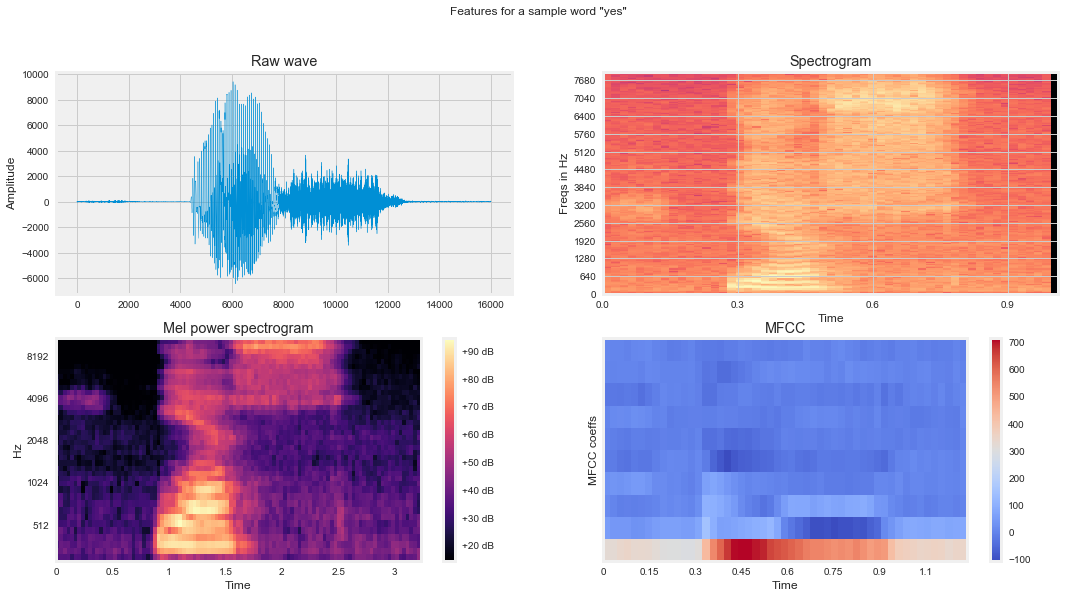

In [10]:
filepath = train_audio_path + filename
_ = extract_plot_features(filepath, plot=True)
IPython.display.Audio(filepath)

In [11]:
def plot_a_sample_word(word=None):
    train_audio_path = '../input/train/audio/'
    if not word:
        word = np.random.choice(labels)
    filename = np.random.choice(os.listdir(train_audio_path + '/' + word))
    filepath = train_audio_path + word + '/' + filename
    _ = extract_plot_features(filepath, plot=True)
    return filepath

../input/train/audio/left/29fb33da_nohash_4.wav
raw sample of shape: (16000,)
log spectrogram of shape: (201, 55)
log mel spectrogram of shape: (40, 101)
mfcc of shape: (10, 51)


/Users/Ren.Zhang@ibm.com/anaconda/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


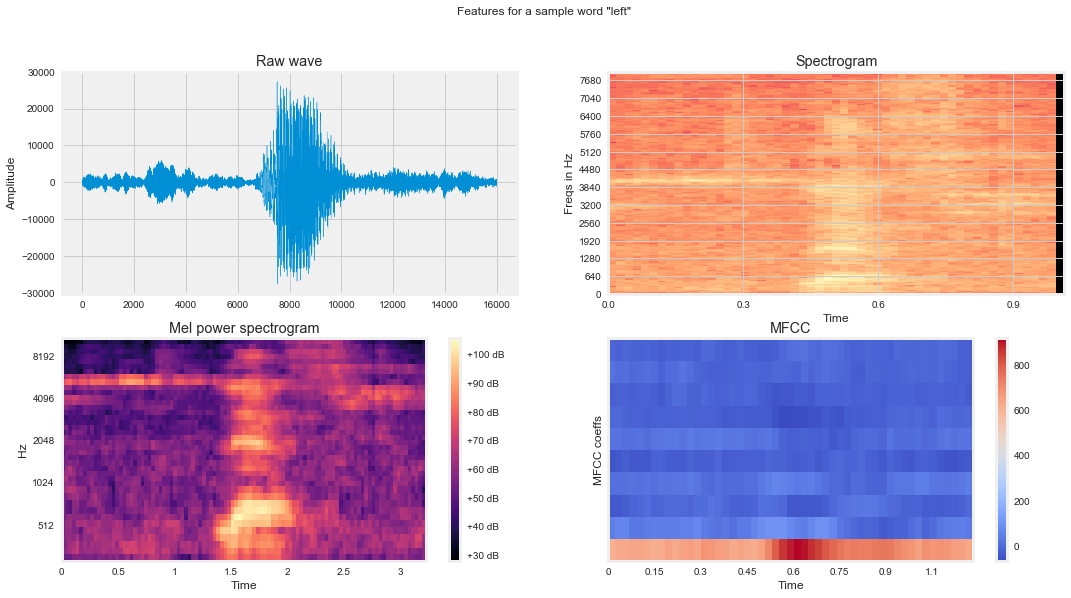

In [16]:
filepath = plot_a_sample_word('left')
IPython.display.Audio(filepath)

../input/train/audio/on/099d52ad_nohash_2.wav
raw sample of shape: (16000,)
log spectrogram of shape: (201, 55)
log mel spectrogram of shape: (40, 101)
mfcc of shape: (10, 51)


/Users/Ren.Zhang@ibm.com/anaconda/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


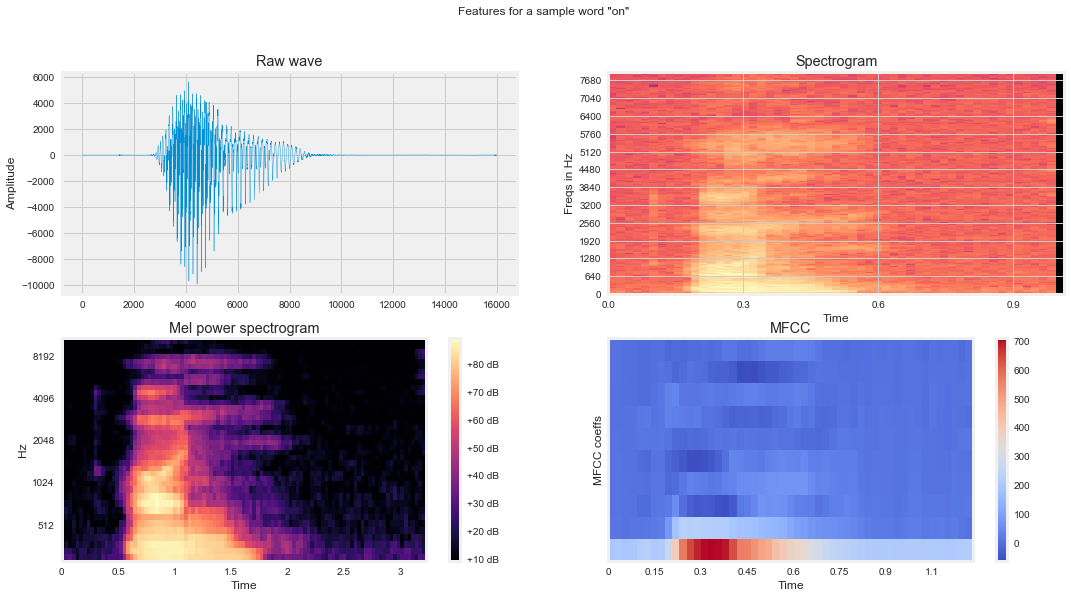

In [22]:
filepath = plot_a_sample_word('on')
IPython.display.Audio(filepath)

../input/train/audio/bird/99e6cab8_nohash_0.wav
raw sample of shape: (16000,)
log spectrogram of shape: (201, 55)
log mel spectrogram of shape: (40, 101)
mfcc of shape: (10, 51)


/Users/Ren.Zhang@ibm.com/anaconda/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


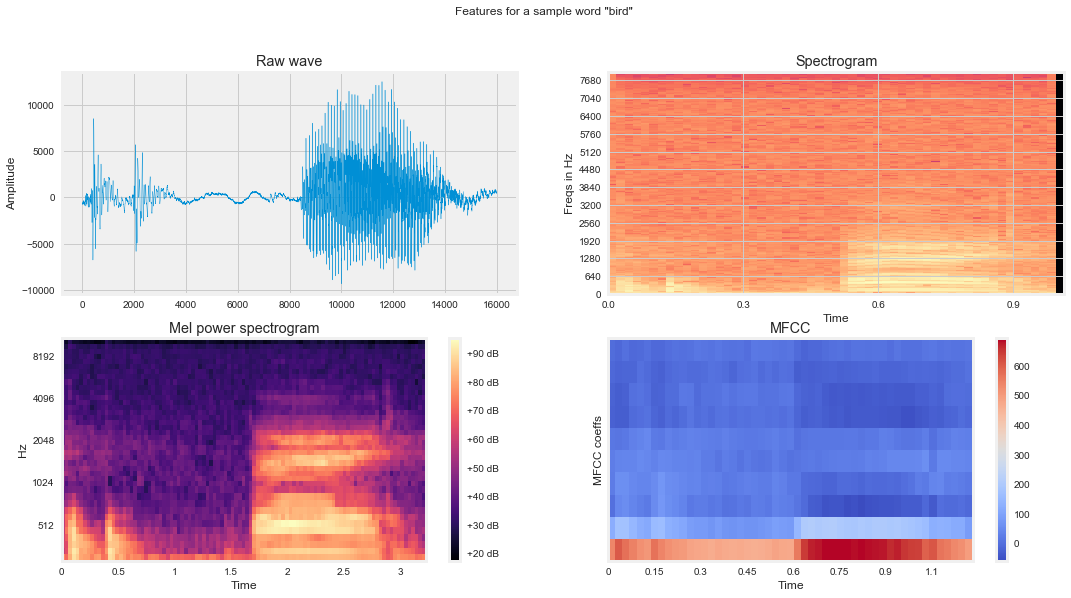

In [29]:
filepath = plot_a_sample_word('bird')
IPython.display.Audio(filepath)